***
***
# 数据清洗之推特数据
***
***

王成军

wangchengjun@nju.edu.cn

计算传播网 http://computational-communication.com

## 数据清洗（data cleaning）
是数据分析的重要步骤，其主要目标是将混杂的数据清洗为可以被直接分析的数据，一般需要将数据转化为数据框（data frame）的样式。

本章将以推特文本的清洗作为例子，介绍数据清洗的基本逻辑。

- 清洗错误行
- 正确分列
- 提取所要分析的内容
- 介绍通过按行、chunk的方式对大规模数据进行预处理




# 1. 抽取tweets样本做实验
此节学生略过

In [23]:
bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-raw.txt', 'r')
chunkSize = 1000000
chunk = bigfile.readlines(chunkSize)
print(len(chunk))
with open("/Users/chengjun/GitHub/cjc/data/ows_tweets_sample.txt", 'w') as f:
    for i in chunk:
        f.write(i)  

2752


# Lazy Method for Reading Big File in Python?

In [6]:
# https://stackoverflow.com/questions/519633/lazy-method-for-reading-big-file-in-python?lq=1
import csv
bigfile = open('/Users/datalab/bigdata/cjc/ows-raw.txt', 'r')

chunkSize = 10**8
chunk = bigfile.readlines(chunkSize)
num, num_lines = 0, 0
while chunk:
    lines = csv.reader((line.replace('\x00','') for line in chunk), 
                       delimiter=',', quotechar='"')
    #do sth.
    num_lines += len(list(lines))
    print(num, num_lines)
    num += 1
    chunk = bigfile.readlines(chunkSize) # read another chunk

0 262665
1 525130
2 787344
3 1049351
4 1312571
5 1574666
6 1835628
7 2097136
8 2358494
9 2619723
10 2880857
11 3140945
12 3404775
13 3665565
14 3927996
15 4189419
16 4449078
17 4709001
18 4969877
19 5230937
20 5492578
21 5756613
22 6022478
23 6286119
24 6549476
25 6602141


# 字节（Byte /bait/）

计算机信息技术用于计量存储容量的一种计量单位，通常情况下一字节等于有八位， [1]  也表示一些计算机编程语言中的数据类型和语言字符。
- 1B（byte，字节）= 8 bit；
- 1KB=1000B；1MB=1000KB=1000×1000B。其中1000=10^3。
- 1KB（kilobyte，千字节）=1000B= 10^3 B；
- 1MB（Megabyte，兆字节，百万字节，简称“兆”）=1000KB= 10^6 B；
- 1GB（Gigabyte，吉字节，十亿字节，又称“千兆”）=1000MB= 10^9 B；

## 用Pandas的get_chunk功能来处理亿级数据

> 只有在超过5TB数据量的规模下，Hadoop才是一个合理的技术选择。

In [ ]:
import pandas as pd

f = open('../bigdata/OWS/ows-raw.txt',encoding='utf-8')
reader = pd.read_table(f,  sep=',',  iterator=True, error_bad_lines=False) #跳过报错行
loop = True
chunkSize = 100000
data = []

while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        dat = data_cleaning_funtion(chunk) # do sth.
        data.append(dat) 
    except StopIteration:
        loop = False
        print("Iteration is stopped.")

df = pd.concat(data, ignore_index=True)

# 2. 清洗错行的情况

In [7]:
with open("../data/ows_tweets_sample.txt", 'r') as f:
    lines = f.readlines() 

In [8]:
# 总行数
len(lines)

2753

In [9]:
# 查看第一行
lines[15]

'121813245488140288,"@HumanityCritic i\'m worried that the #ows sells out to the hamsher-norquist spitefuck, and tries to unite with the teahad.",http://a2.twimg.com/profile_images/627683576/flytits_normal.jpg,2011-10-06,5,5,"2011-10-06 05:05:15",N;,fucentarmal,27480502,en,HumanityCritic,230431,"&lt;a href=&quot;http://www.tweetdeck.com&quot; rel=&quot;nofollow&quot;&gt;TweetDeck&lt;/a&gt;"\n'

In [40]:
help(lines[1].split)

Help on built-in function split:

split(...) method of builtins.str instance
    S.split(sep=None, maxsplit=-1) -> list of strings
    
    Return a list of the words in S, using sep as the
    delimiter string.  If maxsplit is given, at most maxsplit
    splits are done. If sep is not specified or is None, any
    whitespace string is a separator and empty strings are
    removed from the result.



# 问题： 第一行是变量名
> ## 1. 如何去掉换行符？
> ## 2. 如何获取每一个变量名？


In [10]:
varNames = lines[0].replace('\n', '').split(',')
varNames

['"Twitter ID"',
 'Text',
 '"Profile Image URL"',
 'Day',
 'Hour',
 'Minute',
 '"Created At"',
 'Geo',
 '"From User"',
 '"From User ID"',
 'Language',
 '"To User"',
 '"To User ID"',
 'Source']

In [11]:
len(varNames)

14

In [12]:
lines[1344]

'121818600490283009,"RT @chachiTHEgr8: RT @TheNewDeal: First they ignore you, then they laugh at you, then they fight you, then you win. - Gandhi #OccupyWallStreet #OWS #p2",http://a0.twimg.com/profile_images/326662126/Photo_233_normal.jpg,2011-10-06,5,26,"2011-10-06 05:26:32",N;,k_l_h_j,382233343,en,,0,"&lt;a href=&quot;http://twitter.com/#!/download/iphone&quot; rel=&quot;nofollow&quot;&gt;Twitter for iPhone&lt;/a&gt;"\n'

# 如何来处理错误换行情况？

In [7]:
with open("../data/ows_tweets_sample_clean.txt", 'w') as f:
    right_line = '' # 正确的行，它是一个空字符串
    blocks = [] # 确认为正确的行会被添加到blocks里面
    for line in lines:
        right_line += line.replace('\n', ' ')
        line_length = len(right_line.split(','))
        if line_length >= 14:
            blocks.append(right_line)
            right_line = '' 
    for i in blocks:
        f.write(i + '\n')

In [8]:
len(blocks)

2627

In [9]:
blocks[1344]

'121818879105310720,"RT @Min_Reyes: RT @The99Percenters: New video to go viral. From We Are Change http://t.co/6Ff718jk Listen to the guy begging... #ows #cdnpoli",http://a3.twimg.com/sticky/default_profile_images/default_profile_0_normal.png,2011-10-06,5,27,"2011-10-06 05:27:38",N;,MiyazakiMegu,260948518,en,,0,"&lt;a href=&quot;http://www.tweetdeck.com&quot; rel=&quot;nofollow&quot;&gt;TweetDeck&lt;/a&gt;" '

# 同时考虑分列符和引用符

- 分列符🔥分隔符：sep, delimiter
- 引用符☁️：quotechar


In [13]:
import re
re.split(',"|",', lines[15])

['121813245488140288',
 "@HumanityCritic i'm worried that the #ows sells out to the hamsher-norquist spitefuck, and tries to unite with the teahad.",
 'http://a2.twimg.com/profile_images/627683576/flytits_normal.jpg,2011-10-06,5,5',
 '2011-10-06 05:05:15',
 'N;,fucentarmal,27480502,en,HumanityCritic,230431',
 '&lt;a href=&quot;http://www.tweetdeck.com&quot; rel=&quot;nofollow&quot;&gt;TweetDeck&lt;/a&gt;"\n']

In [14]:
import re

with open("../data/ows_tweets_sample.txt",'r') as f:
    lines = f.readlines()
    
for i in range(35,50):
    i_ = re.split(',"|",', lines[i])
    print('line =',i,' length =', len(i_))


line = 35  length = 6
line = 36  length = 6
line = 37  length = 6
line = 38  length = 6
line = 39  length = 6
line = 40  length = 6
line = 41  length = 2
line = 42  length = 5
line = 43  length = 6
line = 44  length = 6
line = 45  length = 6
line = 46  length = 6
line = 47  length = 6
line = 48  length = 2
line = 49  length = 5


In [15]:
with open("../data/ows_tweets_sample_clean4.txt", 'w') as f:
    right_line = '' # 正确的行，它是一个空字符串
    blocks = [] # 确认为正确的行会被添加到blocks里面
    for line in lines:
        right_line += line.replace('\n', ' ').replace('\r', ' ')
        #line_length = len(right_line.split(','))
        i_ = re.split(',"|",', right_line)
        line_length = len(i_)
        if line_length >= 6:
            blocks.append(right_line)
            right_line = ''
#     for i in blocks:
#         f.write(i + '\n')

In [16]:
len(blocks)

2626

# 3. 读取数据、正确分列

In [18]:
# 提示：你可能需要修改以下路径名
with open("../data/ows_tweets_sample.txt", 'r') as f:
    chunk = f.readlines()

In [19]:
len(chunk)

2753

In [20]:
chunk[:3]

['"Twitter ID",Text,"Profile Image URL",Day,Hour,Minute,"Created At",Geo,"From User","From User ID",Language,"To User","To User ID",Source\n',
 '121813144174727168,"RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE RT !!HELP!!!!",http://a2.twimg.com/profile_images/1539375713/Twitter_normal.jpg,2011-10-06,5,4,"2011-10-06 05:04:51",N;,Anonops_Cop,401240477,en,,0,"&lt;a href=&quot;http://twitter.com/&quot;&gt;web&lt;/a&gt;"\n',
 '121813146137657344,"@jamiekilstein @allisonkilkenny Interesting interview (never aired, wonder why??) by Fox with #ows protester http://t.co/Fte55Kh7",http://a2.twimg.com/profile_images/1574715503/Kate6_normal.jpg,2011-10-06,5,4,"2011-10-06 05:04:51",N;,KittyHybrid,34532053,en,jamiekilstein,2149053,"&lt;a href=&quot;http://twitter.com/&quot;&gt;web&lt;/a&gt;"\n']

In [21]:
import csv
lines_csv = csv.reader(chunk, delimiter=',', quotechar='"') 
print(len(list(lines_csv)))
# next(lines_csv)
# next(lines_csv)

2627


In [27]:
import re
import csv

from collections import defaultdict

def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_user_name = rt_patterns.findall(tweet)
    if rt_user_name:
        rt_user_name = rt_user_name[0][1].strip(' @')
    else:
        rt_user_name = None
    return rt_user_name

rt_network = defaultdict(int)
f = open("../data/ows_tweets_sample.txt", 'r')
chunk = f.readlines(100000)
while chunk:   
    #lines = csv.reader(chunk, delimiter=',', quotechar='"') 
    lines = csv.reader((line.replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
    for line in lines:
        tweet = line[1]
        from_user = line[8]
        rt_user = extract_rt_user(tweet)
        rt_network[(from_user, rt_user)] += 1    
    chunk = f.readlines(100000)

In [22]:
import pandas as pd
df = pd.read_csv("../data/ows_tweets_sample.txt",
                 sep = ',', quotechar='"')
df[:3]

Twitter ID                                               Text  \
0  121813144174727168  RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLIN...   
1  121813146137657344  @jamiekilstein @allisonkilkenny Interesting in...   
2  121813150000619521  @Seductivpancake Right! Those guys have a vict...   

                                   Profile Image URL         Day  Hour  \
0  http://a2.twimg.com/profile_images/1539375713/...  2011-10-06     5   
1  http://a2.twimg.com/profile_images/1574715503/...  2011-10-06     5   
2  http://a1.twimg.com/profile_images/1241412831/...  2011-10-06     5   

   Minute           Created At Geo    From User  From User ID Language  \
0       4  2011-10-06 05:04:51  N;  Anonops_Cop     401240477       en   
1       4  2011-10-06 05:04:51  N;  KittyHybrid      34532053       en   
2       4  2011-10-06 05:04:52  N;   nerdsherpa      95067344       en   

           To User  To User ID  \
0              NaN           0   
1    jamiekilstein     2149053   
2  Seductivpancake    19695580   

                                              Source  
0  &lt;a href=&quot;http://twitter.com/&quot;&gt;...  
1  &lt;a href=&quot;http://twitter.com/&quot;&gt;...  
2  &lt;a href=&quot;http://www.echofon.com/&quot;...

In [23]:
len(df)

2626

In [24]:
df.Text[0]

'RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE RT !!HELP!!!!'

In [25]:
df['From User'][:10]

0       Anonops_Cop
1       KittyHybrid
2        nerdsherpa
3        hamudistan
4           kl_knox
5     vickycrampton
6    burgerbuilders
7          neverfox
8       davidgaliel
9           AnonOws
Name: From User, dtype: object

# 4. 统计数量
### 统计发帖数量所对应的人数的分布
> 人数在发帖数量方面的分布情况

In [26]:
from collections import defaultdict
data_dict = defaultdict(int)
for i in df['From User']:
    data_dict[i] +=1 

In [27]:
list(data_dict.items())[:5]
#data_dict

[('MiranHosny', 1),
 ('BradMarston', 1),
 ('Sir_Richard_311', 1),
 ('elChepi', 1),
 ('jboy', 1)]

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

### 安装微软雅黑字体
为了在绘图时正确显示中文，需要安装/data/文件夹中的微软雅黑字体（msyh.ttf）

详见[common questions](0.common_questions.ipynb)

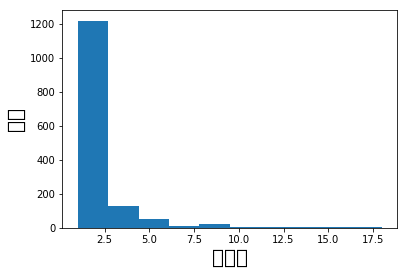

In [29]:
plt.hist(data_dict.values())
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(u'发帖数', fontsize = 20)
plt.ylabel(u'人数', fontsize = 20)
plt.show()

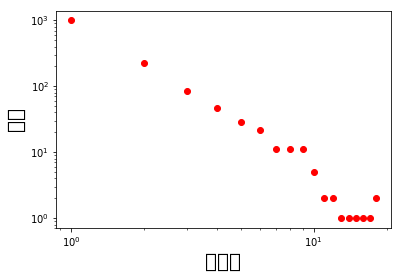

In [30]:
tweet_dict = defaultdict(int)
for i in data_dict.values():
    tweet_dict[i] += 1
 
plt.loglog(tweet_dict.keys(), tweet_dict.values(), 'ro')#linewidth=2)  
plt.xlabel(u'推特数', fontsize=20)
plt.ylabel(u'人数', fontsize=20 )
plt.show()

In [31]:
import numpy as np
import statsmodels.api as sm

def powerPlot(d_value, d_freq, color, marker):
    d_freq = [i + 1 for i in d_freq]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, linestyle = '',\
             color = color, marker = marker)
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/2,max(d_prob)/10,
             r'$\beta$ = ' + str(round(beta,2)) +'\n' + r'$R^2$ = ' + str(round(r2, 2)), fontsize = 20)

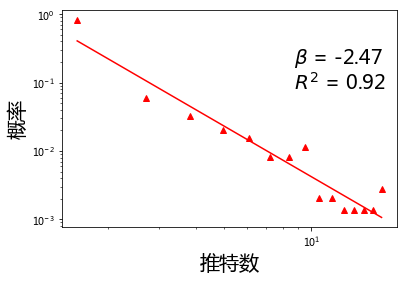

In [31]:
histo, bin_edges = np.histogram(list(data_dict.values()), 15)
bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])
powerPlot(bin_center,histo, 'r', '^')
#lg=plt.legend(labels = [u'Tweets', u'Fit'], loc=3, fontsize=20)
plt.ylabel(u'概率', fontsize=20)
plt.xlabel(u'推特数', fontsize=20) 
plt.show()

In [32]:
import statsmodels.api as sm
from collections import defaultdict
import numpy as np

def powerPlot2(data):
    d = sorted(data, reverse = True )
    d_table = defaultdict(int)
    for k in d:
        d_table[k] += 1
    d_value = sorted(d_table)
    d_value = [i+1 for i in d_value]
    d_freq = [d_table[i]+1 for i in d_value]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, 'ro')
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/2,max(d_prob)/5,
             'Beta = ' + str(round(beta,2)) +'\n' + 'R squared = ' + str(round(r2, 2)))
    plt.title('Distribution')
    plt.ylabel('P(K)')
    plt.xlabel('K')
    plt.show()
    

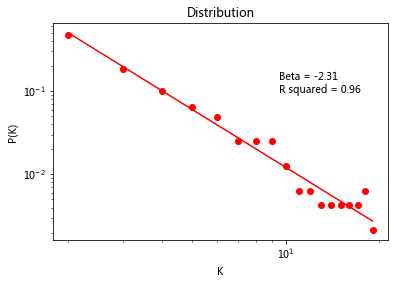

In [33]:
powerPlot2(data_dict.values())

In [34]:
import powerlaw
def plotPowerlaw(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=2)
    #fit = powerlaw.Fit(data)
    fit.plot_pdf(color = col, linewidth = 2)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    fit.power_law.plot_pdf(color = col, linestyle = 'dotted', ax = ax, \
                            label = r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x))
    ax.set_xlabel(xlab, fontsize = 20)
    ax.set_ylabel('$Probability$', fontsize = 20)
    plt.legend(loc = 0, frameon = False)

In [35]:
from collections import defaultdict
data_dict = defaultdict(int)

for i in df['From User']:
    data_dict[i] += 1

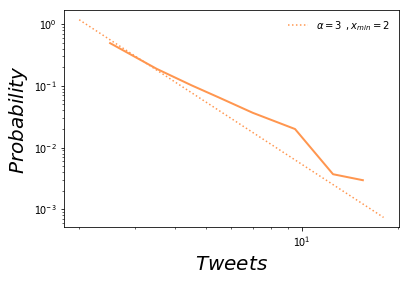

In [36]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(6, 4),facecolor='white')
ax = fig.add_subplot(1, 1, 1)
plotPowerlaw(list(data_dict.values()), ax,cmap(1), 
             '$Tweets$')

# 5. 清洗tweets文本

In [1]:
tweet = '''RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

In [32]:
import re

import twitter_text
# https://github.com/dryan/twitter-text-py/issues/21
#Macintosh HD ▸ 用户 ▸ datalab ▸ 应用程序 ▸ anaconda ▸ lib ▸ python3.5 ▸ site-packages

# 安装twitter_text

[twitter-text-py](https://github.com/dryan/twitter-text-py/issues/21) could not be used for python 3


> ### <del>pip install twitter-text</del>

Glyph debug the problem, and make [a new repo of twitter-text-py3](https://github.com/glyph/twitter-text-py).

> ## pip install twitter-text


# 无法正常安装的同学
## 可以在spyder中打开terminal安装

pip install twitter-text

In [35]:
import re

tweet = '''RT @AnonKitsu: @who ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", \
                         re.IGNORECASE)
rt_user_name = rt_patterns.findall(tweet)[0][1].strip(' @')#.split(':')[0]
rt_user_name

'AnonKitsu: @who'

In [28]:
import re

tweet = '''RT @AnonKitsu: @who ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", \
                         re.IGNORECASE)
rt_user_name = rt_patterns.findall(tweet)[0][1].strip(' @').split(':')[0]
rt_user_name

'AnonKitsu'

In [36]:
import re

tweet = '''@chengjun:@who ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
rt_user_name = rt_patterns.findall(tweet)
print(rt_user_name)

if rt_user_name:
    print('it exits.')
else:
    print('None')

[]
None


In [37]:
import re

def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_user_name = rt_patterns.findall(tweet)
    if rt_user_name:
        rt_user_name = rt_user_name[0][1].strip(' @').split(':')[0]
    else:
        rt_user_name = None
    return rt_user_name

In [38]:
tweet = '''RT @chengjun: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

extract_rt_user(tweet)    

'chengjun'

In [39]:
tweet = '''@chengjun: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

print(extract_rt_user(tweet) )

None


In [40]:
import csv

with open("../data/ows_tweets_sample.txt", 'r') as f:
    chunk = f.readlines()
    
rt_network = []
lines = csv.reader(chunk[1:], delimiter=',', quotechar='"')
tweet_user_data = [(i[1], i[8]) for i in lines]
tweet_user_data[:3]

[('RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE RT !!HELP!!!!',
  'Anonops_Cop'),
 ('@jamiekilstein @allisonkilkenny Interesting interview (never aired, wonder why??) by Fox with #ows protester http://t.co/Fte55Kh7',
  'KittyHybrid'),
 ("@Seductivpancake Right! Those guys have a victory condition: regime change. #ows doesn't seem to have a goal I can figure out.",
  'nerdsherpa')]

In [41]:
from collections import defaultdict

rt_network = []
rt_dict = defaultdict(int)
for k, i  in enumerate(tweet_user_data):
    tweet,user = i
    rt_user = extract_rt_user(tweet)
    if rt_user:
        rt_network.append((user, rt_user)) #(rt_user,'  ', user, end = '\n')
        rt_dict[(user, rt_user)] += 1
#rt_network[:5]
list(rt_dict.items())[:3]

[(('OccupyNCGBORO', 'angela0328'), 1),
 (('evlance', 'KeithOlbermann'), 1),
 (('Lusho0487', 'anonops'), 1)]

# 获得清洗过的推特文本

不含人名、url、各种符号（如RT @等）

In [42]:
def extract_tweet_text(tweet, at_names, urls):
    for i in at_names:
        tweet = tweet.replace(i, '')
    for j in urls:
        tweet = tweet.replace(j, '')
    marks = ['RT @', '@', '&quot;', '#', '\n', '\t', '  ']
    for k in marks:
        tweet = tweet.replace(k, '')
    return tweet

In [43]:
import twitter_text

tweet = '''RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

ex = twitter_text.Extractor(tweet)
at_names = ex.extract_mentioned_screen_names()
urls = ex.extract_urls()
hashtags = ex.extract_hashtags()
rt_user = extract_rt_user(tweet)
#tweet_text = extract_tweet_text(tweet, at_names, urls)

print(at_names, urls, hashtags, rt_user,'-------->')#, tweet_text)

['AnonKitsu', 'chengjun', 'mili'] ['http://computational-communication.com', 'http://ccc.nju.edu.cn'] ['OCCUPYWALLSTREET', 'OWS', 'OCCUPYNY'] AnonKitsu -------->


In [44]:
import csv

lines = csv.reader(chunk,delimiter=',', quotechar='"')
tweets = [i[1] for i in lines]

In [45]:
for tweet in tweets[:5]:
    ex = twitter_text.Extractor(tweet)
    at_names = ex.extract_mentioned_screen_names()
    urls = ex.extract_urls()
    hashtags = ex.extract_hashtags()
    rt_user = extract_rt_user(tweet)
    #tweet_text = extract_tweet_text(tweet, at_names, urls)

    print(at_names, urls, hashtags, rt_user)
    #print(tweet_text)

[] [] [] None
['AnonKitsu'] [] ['OCCUPYWALLSTREET', 'OWS', 'OCCUPYNY'] AnonKitsu
['jamiekilstein', 'allisonkilkenny'] ['http://t.co/Fte55Kh7'] ['ows'] None
['Seductivpancake'] [] ['ows'] None
['bembel'] ['http://j.mp/rhHavq'] ['OccupyWallStreet', 'OWS'] bembel


# 思考：

### 提取出raw tweets中的rtuser与user的转发网络

## 格式：
rt_user1, user1, 3

rt_user2, user3, 2

rt_user2, user4, 1

...

数据保存为csv格式

# 阅读文献